# 05 Backtesting and Evaluation

The goal is to show that ML beat baseline overall and seek for practice by utlizing the forcast

### 1. Imports and load predictions

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
pred = pd.read_csv("../data_processed/predictions_regression.csv", index_col=0, parse_dates=True)
pred.head(), pred.shape

(            true_vol  baseline_vol  ridge_vol   gbr_vol
 Date                                                   
 2024-01-02  0.108077      0.097642   0.105712  0.128402
 2024-01-03  0.108733      0.100905   0.110576  0.119489
 2024-01-04  0.108471      0.102149   0.111919  0.120156
 2024-01-05  0.098445      0.100145   0.111051  0.145376
 2024-01-08  0.099294      0.107772   0.114406  0.138947,
 (497, 4))

### 2. Summarize of the predictions performance

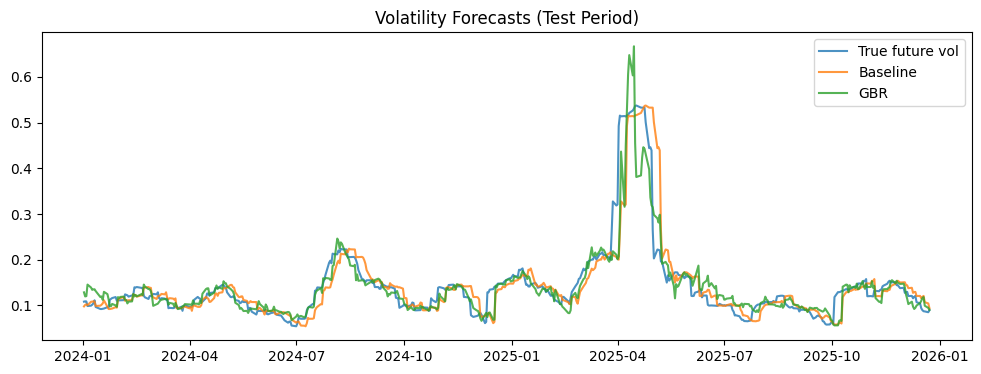

,model,MAE,RMSE
0,baseline,0.021680,0.041522
1,gbr,0.019927,0.034419


In [22]:
def mae(a, b):
    return float(np.mean(np.abs(a - b)))

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

summary = pd.DataFrame([
    {"model": "baseline", "MAE": mae(pred["true_vol"], pred["baseline_vol"]), "RMSE": rmse(pred["true_vol"], pred["baseline_vol"])},
    {"model": "gbr",      "MAE": mae(pred["true_vol"], pred["gbr_vol"]),      "RMSE": rmse(pred["true_vol"], pred["gbr_vol"])}
])

plt.figure(figsize=(12,4))
plt.plot(pred.index, pred["true_vol"], label="True future vol", alpha=0.8)
plt.plot(pred.index, pred["baseline_vol"], label="Baseline", alpha=0.8)
plt.plot(pred.index, pred["gbr_vol"], label="GBR", alpha=0.8)
plt.title("Volatility Forecasts (Test Period)")
plt.legend()
plt.show()

summary

### 3. Rolling errors
- rolling errors should be accurate in order to be stable instead of being "better in average"

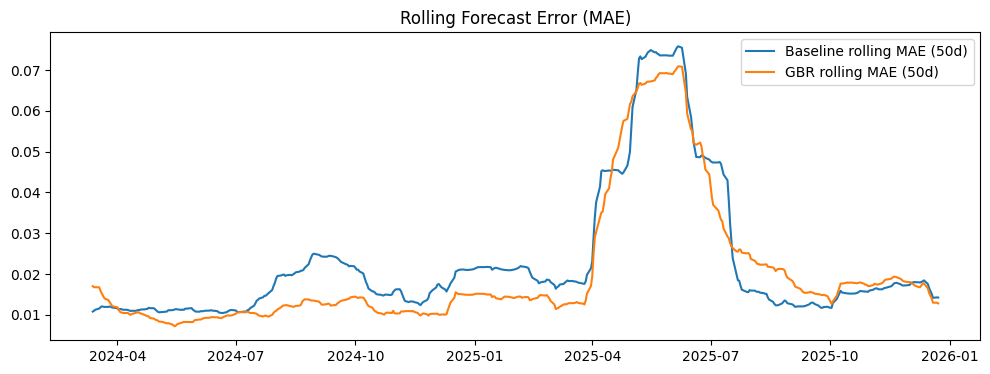

In [23]:
window = 50

pred["abs_err_base"] = (pred["true_vol"] - pred["baseline_vol"]).abs()
pred["abs_err_gbr"] = (pred["true_vol"] - pred["gbr_vol"]).abs()

pred["roll_mae_base"] = pred["abs_err_base"].rolling(window).mean()
pred["roll_mae_gbr"] = pred["abs_err_gbr"].rolling(window).mean()

plt.figure(figsize=(12,4))
plt.plot(pred.index, pred["roll_mae_base"], label=f"Baseline rolling MAE ({window}d)")
plt.plot(pred.index, pred["roll_mae_gbr"], label=f"GBR rolling MAE ({window}d)")
plt.title("Rolling Forecast Error (MAE)")
plt.legend()
plt.show()

### 4. Performance in regime
- we want to show that ML performs better in stressed regime

In [24]:
# filter out only the top 20% most volatile days
q = pred["true_vol"].quantile(0.8)
# label high volatility regime as 1, low volatility regime as 0
pred["high_vol_regime"] = (pred["true_vol"] >= q).astype(int)

# split in 2 groups and compute error metrics in each regime
regime_summary = pred.groupby("high_vol_regime").apply(
    lambda x: pd.Series({
        "n_days": len(x),
        "baseline_MAE": mae(x["true_vol"], x["baseline_vol"]),
        "gbr_MAE": mae(x["true_vol"], x["gbr_vol"]),
        "baseline_RMSE": rmse(x["true_vol"], x["baseline_vol"]),
        "gbr_RMSE": rmse(x["true_vol"], x["gbr_vol"]),
    })
)

regime_summary


/var/folders/3g/lbd99xz94p179sd0d5kgsb6r0000gp/T/ipykernel_92648/2750111655.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  regime_summary = pred.groupby("high_vol_regime").apply(


,n_days,baseline_MAE,gbr_MAE,baseline_RMSE,gbr_RMSE
high_vol_regime,,,,,
0,397.0,0.015238,0.014523,0.020454,0.019397
1,100.0,0.047253,0.041383,0.083112,0.066289


### 5. GBR predictions performance
- a good performance should have most of the points lying or near the diagonal line

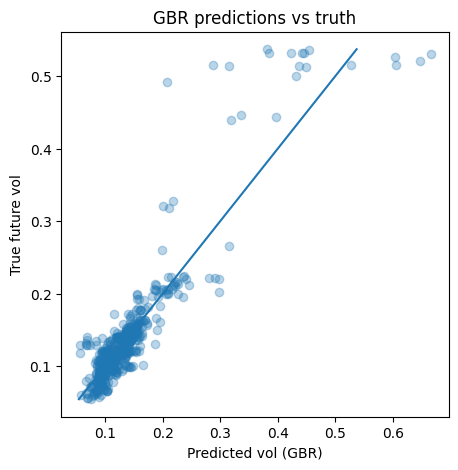

In [25]:
plt.figure(figsize=(5,5))
plt.scatter(pred["gbr_vol"], pred["true_vol"], alpha=0.3)
plt.xlabel("Predicted vol (GBR)")
plt.ylabel("True future vol")
plt.title("GBR predictions vs truth")
plt.plot([pred["true_vol"].min(), pred["true_vol"].max()],
         [pred["true_vol"].min(), pred["true_vol"].max()])
plt.show()


### 6. Implementation into a strategy
- high volatility, hold less
- low volatility, hold more
- the portfolio is kept at a stable risk
- compare the performance with baseline strategy

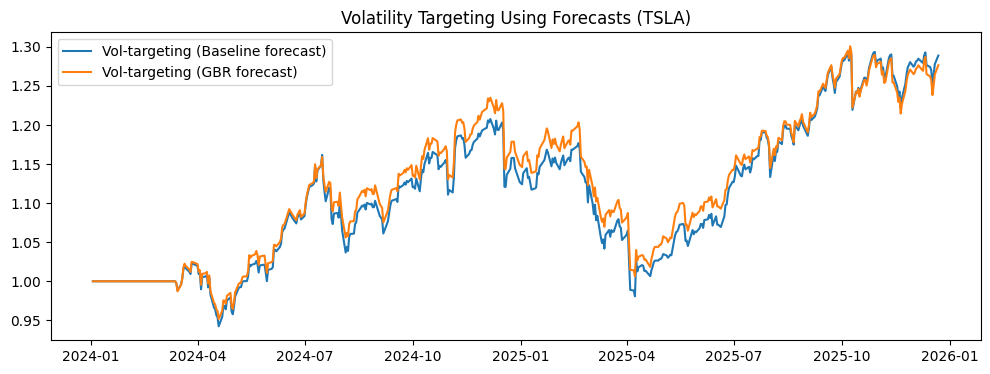

In [26]:
import yfinance as yf

ticker = "SPY"
raw = yf.download(ticker, start=pred.index.min(), end=pred.index.max(), progress=False, auto_adjust=True)
prices = raw["Close"].squeeze().dropna()
rets = np.log(prices).diff().dropna()

rets = rets.reindex(pred.index).dropna()
pred_aligned = pred.reindex(rets.index).dropna()

# 15% annual target risk
target_vol = 0.15  

# exposure weights (clipped to max 2x leverage)
# reduce exposure when predicted vol is higher than target, increase exposure when predicted vol is lower than target
w_base = np.clip(target_vol / pred_aligned["baseline_vol"], 0, 2)
w_gbr  = np.clip(target_vol / pred_aligned["gbr_vol"], 0, 2)

# Strategy returns
ret_base = (w_base.shift(1) * rets).fillna(0)
ret_gbr  = (w_gbr.shift(1) * rets).fillna(0)

# form equity curves (+1 to represent growth of $1 invested)
eq_base = (1 + ret_base).cumprod()
eq_gbr  = (1 + ret_gbr).cumprod()

plt.figure(figsize=(12,4))
plt.plot(eq_base.index, eq_base.values, label="Vol-targeting (Baseline forecast)")
plt.plot(eq_gbr.index, eq_gbr.values, label="Vol-targeting (GBR forecast)")
plt.title("Volatility Targeting Using Forecasts (TSLA)")
plt.legend()
plt.show()
